In [6]:
#Interview must-know:

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.num_patches =(img_size//patch_size)**2 #needed in ViT
    self.cnn = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, img): #img: (B,3,H,W)
    img = self.cnn(img) #img: (B,embed_dim,H',W')
    img = img.flatten(2) #img : (B,embed_dim,H'*W') = (B,embed_dim,num_patches)
    img = img.transpose(1,2) # img: (B,num_patches,embed_dim)
    return img

class PositionalEncoding(nn.Module):
  def __init__(self, seq_len, embed_dim):
    super().__init__()
    self.pe = nn.Parameter(torch.randn(1,seq_len,embed_dim))

  def forward(self, patch_embed):
    return patch_embed + self.pe

class MultiHeadSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()
    self.num_heads = num_heads # only parameter needed
    self.head_dim = embed_dim // num_heads

    self.W_Q = nn.Linear(embed_dim, embed_dim)
    self.W_K = nn.Linear(embed_dim, embed_dim)
    self.W_V = nn.Linear(embed_dim, embed_dim)
    self.W_O = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    batch_size, seq_len, embed_dim = x.size()
    Q = self.W_Q(x)
    K = self.W_K(x)
    V = self.W_V(x)
    Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2) # (batch_size, num_heads, seq_len, head_dim) 0-index
    K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2)
    V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2)
    scores = Q @ K.transpose(-2,-1)/math.sqrt(self.head_dim) # (batch_size, num_heads, seq_len, seq_len)
    attn_weights = F.softmax(scores, dim=-1)
    attn_output = attn_weights @ V # (batch_size, num_heads, seq_len, head_dim)
    attn_output = attn_output.transpose(1,2).contiguous().view(batch_size, seq_len, embed_dim) # .view() require that the tensor is contiguous after transpose
    output = self.W_O(attn_output)
    return output

class TransformerEncoder(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim):
    super().__init__()
    self.prenorm = nn.LayerNorm(embed_dim)
    self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
    self.postnorm = nn.LayerNorm(embed_dim)
    self.mlp = nn.Sequential(
        nn.Linear(embed_dim, mlp_dim),
        nn.GELU(),
        nn.Linear(mlp_dim, embed_dim)
    )

  def forward(self, x):
    x = x + self.attn(self.prenorm(x))
    x = x + self.mlp(self.postnorm(x))
    return x

class ViT(nn.Module):
  def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, num_heads=12, mlp_dim=4*768, num_layers=12, num_classes=10): #initialize once
    super().__init__()
    self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
    self.positional_encoding = PositionalEncoding(self.patch_embedding.num_patches+1, embed_dim)
    self.encoder = nn.Sequential(*[TransformerEncoder(embed_dim, num_heads, mlp_dim) for _ in range(num_layers)]) #nn.Sequential expects each layer as a separate positional argument, not a list
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, img):
    patch_embed = self.patch_embedding(img)
    cls_token = self.cls_token.expand(img.size(0), -1, -1) #expand the CLS token to all batches
    patch_embed = torch.cat([cls_token, patch_embed], dim=1)  # Shape: (B, 1 + num_patches, C)
    patch_embed = self.positional_encoding(patch_embed)
    x = self.encoder(patch_embed)
    x = self.norm(x)
    cls_output = x[:, 0]
    logits = self.head(cls_output)
    return logits

model = ViT()
dummy_img = torch.randn(2, 3, 224, 224)  # (batch, channels, H, W)
out = model(dummy_img)
print(out)

tensor([[ 0.0505,  0.3446, -0.8408,  1.0108,  0.5395, -0.2460,  0.4300,  0.2618,
          0.7520, -0.2152],
        [ 0.1122,  0.3242, -0.8316,  0.9872,  0.5173, -0.2476,  0.5022,  0.2766,
          0.8222, -0.2264]], grad_fn=<AddmmBackward0>)


Suppose input is:

[B, 3, 224, 224]
Applying the Conv2d:

[B, 768, 14, 14]
Explanation:

224
/
16
=
14
224/16=14 patches along each axis

total
14
×
14
=
196
14×14=196 patches

Each patch is mapped to a 768-dimensional vector.

Then you flatten spatial (14, 14) to sequence:


x = x.flatten(2)       # [B, 768, 196]
x = x.transpose(1, 2)  # [B, 196, 768]
Now you have exactly what ViT expects.



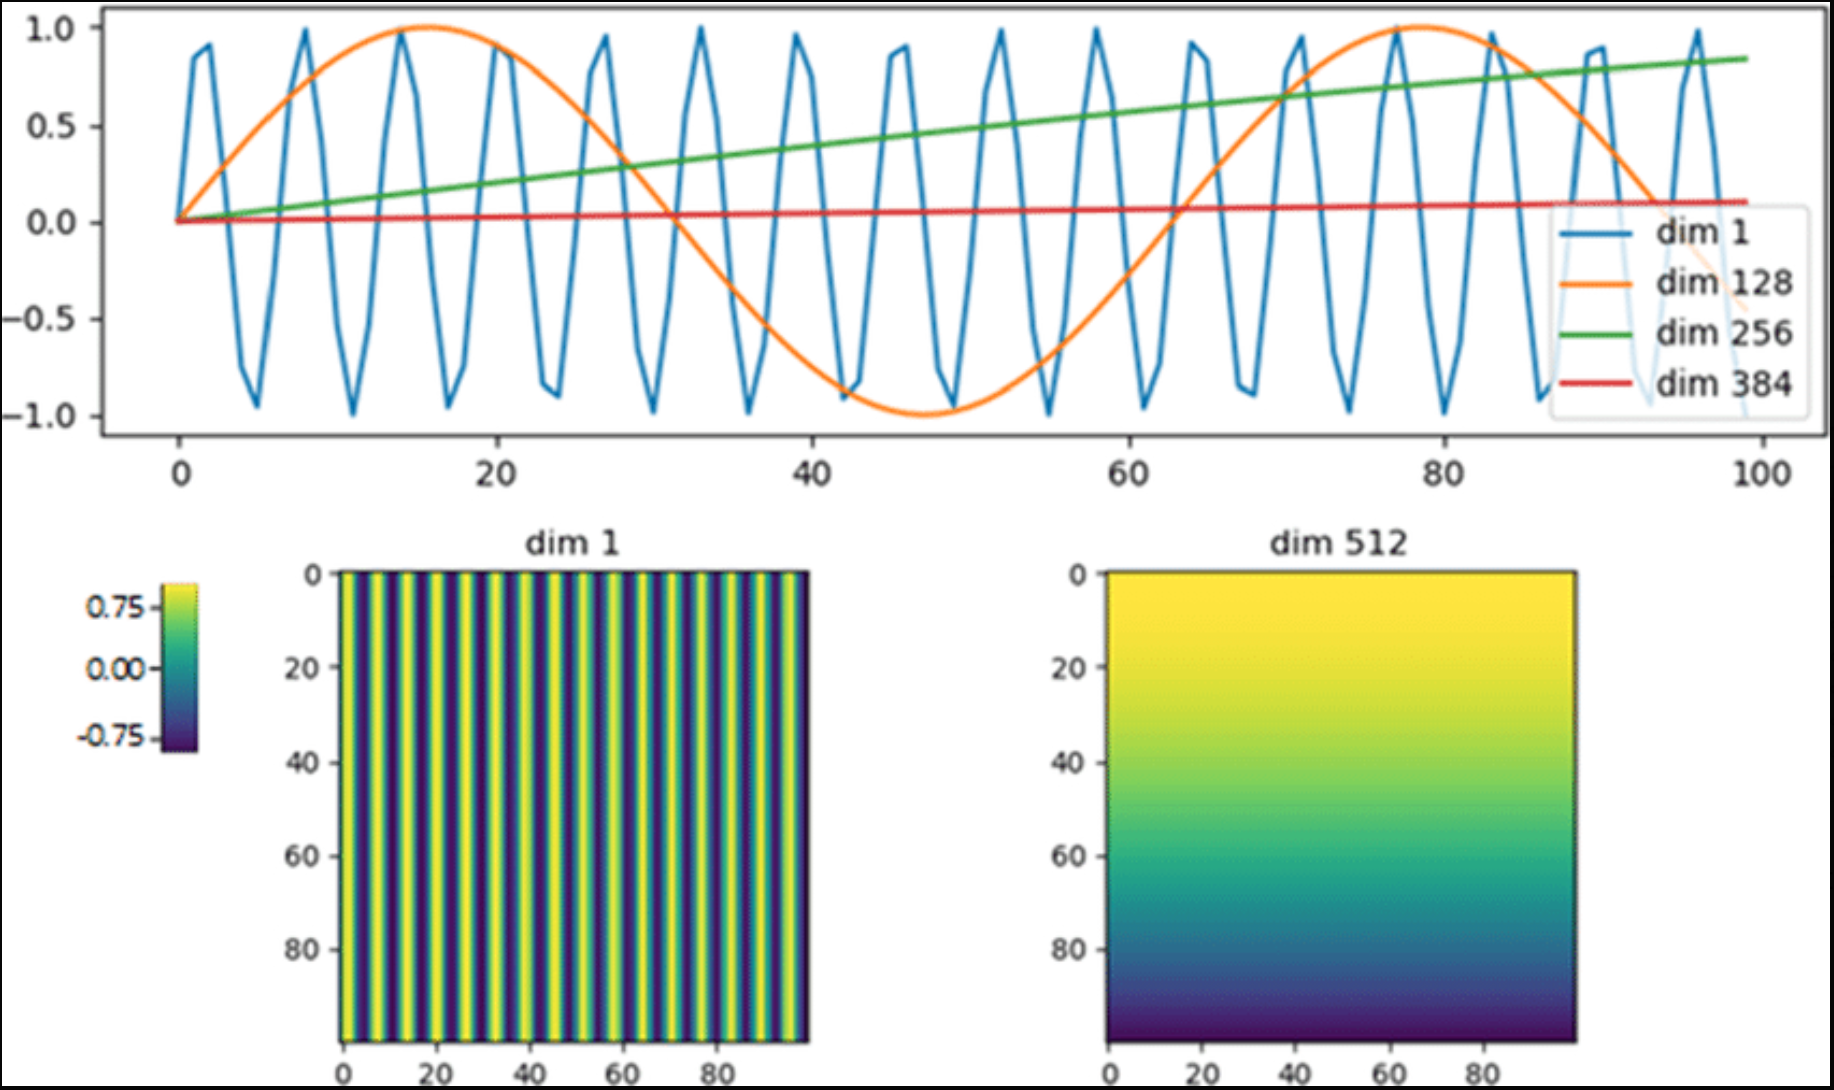

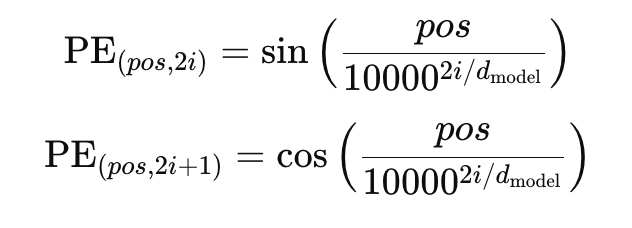

In [7]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=5000):
      super().__init__()
      pos = torch.arange(max_len).unsqueeze(1)               # [max_len, 1] position of the token
      two_i = torch.arange(0, d_model, 2)                        # [0, 2, 4, ..., d_model] position of the embedding
      angle_rates = 1 / (10000 ** (two_i / d_model))             # [d_model/2]
      pe = torch.zeros(max_len, d_model)
      phase_angles = pos * angle_rates                       # shape: [max_len, d_model // 2]
      pe[:, 0::2] = torch.sin(phase_angles)                  # even dims: sin Start at column 0, step by 2 → picks even indices
      pe[:, 1::2] = torch.cos(phase_angles)                  # odd dims: cos Start at column 1, step by 2 → picks even indices
      self.register_buffer("pe", pe)                         # store as non-param

  def forward(self,x):
    """
        x: [batch_size, seq_len, d_model]
    """
    # Get positional encodings up to sequence length T
    pe = self.pe[:x.size(1)]        # shape: [T, D] self.pe was registered via self.register_buffer('pe', pe), you can still access it exactly like a normal attribute

    # Add a batch dimension so it can broadcast across B
    pe = pe.unsqueeze(0)            # shape: [1, T, D]

    # Add position encodings to input
    x = x + pe                      # shape: [B, T, D]

    return x

class MultiHeadSelfAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super().__init__()
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    self.d_model = d_model
    self.num_heads = num_heads
    self.d_head = d_model // num_heads

    self.W_Q = nn.Linear(d_model, d_model, bias=False)
    self.W_K = nn.Linear(d_model, d_model, bias=False)
    self.W_V = nn.Linear(d_model, d_model, bias=False)
    self.W_O = nn.Linear(d_model, d_model, bias=False)

  def forward(self, x, mask=None):
    """
        x: [batch_size, seq_len, d_model]
        mask: [batch_size, seq_len]
        """
    batch_size, seq_len, d_model = x.size()
    Q = self.W_Q(x)
    K = self.W_K(x)
    V = self.W_V(x)

    Q.view(batch_size, seq_len, self.num_heads, self.d_head).transpose(1,2)
    K.view(batch_size, seq_len, self.num_heads, self.d_head).transpose(1,2)
    V.view(batch_size, seq_len, self.num_heads, self.d_head).transpose(1,2)

    scores = torch.matmul(Q, K.transpose(-2,-1))/ math.sqrt(self.d_head)

    scores = scores.masked_fill(mask==0, float('-inf')) if mask is not None else scores
    attn_weights = torch.softmax(scores, dim=-1)
    attention = torch.matmul(attn_weights, V)
    attention = attention.transpose(1,2).contiguous().view(batch_size, seq_len, d_model)
    output = self.W_O(attention)

    return output


class TransformerEncoderBlock(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
    super().__init__()
    self.attention = MultiHeadSelfAttention(d_model, num_heads)
    self.layer_norm1 = nn.LayerNorm(d_model)
    self.layer_norm2 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.mlp = nn.Sequential(
        nn.Linear(d_model, d_ff),
        nn.ReLU(),
        nn.Linear(d_ff, d_model)
    )

  def forward(self, x, mask=None):
    attention_output = self.attention(x, mask)
    x = x + self.dropout1(attention_output)
    x = self.layer_norm1(x)

    mlp_output = self.mlp(x)
    x = x + self.dropout2(mlp_output)
    self.layer_norm2(x)

    return x

class TransformerClassifier(nn.Module):
  def __init__(self, vocab_size, d_model=128, num_heads=4, d_ff=256, max_len=100, num_classes = 10, dropout=0.1):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.positional_encoding = PositionalEncoding(d_model, max_len)
    self.encoder_block = TransformerEncoderBlock(d_model, num_heads, d_ff, dropout)
    self.dropout = nn.Dropout(dropout)
    self.classifier = nn.Linear(d_model, num_classes)

  def forward(self, x, mask=None):
    x = self.embedding(x)
    x = self.positional_encoding(x)
    x = self.encoder_block(x, mask)
    x = x.mean(dim=1)
    logits = self.classifier(x)
    return logits

In [8]:
if __name__ == "__main__":
    batch_size = 2
    seq_len = 5
    vocab_size = 50

    dummy_input = torch.randint(0, vocab_size, (batch_size, seq_len))

    model = TransformerClassifier(
        vocab_size=vocab_size,
        d_model=128,
        num_heads=4,
        d_ff=256,
        max_len=100,
        num_classes=10
    )

    output = model(dummy_input)
    print("Logits shape:", output.shape)

    labels = torch.randint(0, 10, (batch_size,))
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, labels)
    print("Loss:", loss.item())

    loss.backward()


Logits shape: torch.Size([2, 10])
Loss: 2.026003360748291


In [ ]:
from torch.utils.data import Dataset, DataLoader
import random

class EvenOddDataset(Dataset):
    """
    Each sample is:
      - A random sequence of integers in [0..vocab_size-1].
      - Label = 0 if sum of tokens is even, else 1 if odd.
    """
    def __init__(self, size, seq_len, vocab_size):
        super().__init__()
        self.size = size
        self.seq_len = seq_len
        self.vocab_size = vocab_size

        # Pre-generate all samples
        self.data = []
        for _ in range(size):
            tokens = torch.randint(0, vocab_size, (seq_len,))
            sum_tokens = tokens.sum().item()
            label = sum_tokens % 2  # 0 if even, 1 if odd
            self.data.append((tokens, label))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device='cpu'):
    model.train()
    total_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)  # [B, 2]
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate_model(model, val_loader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)  # [B, 2]
            preds = logits.argmax(dim=-1)  # [B]
            correct += (preds == batch_y).sum().item()
            total += batch_x.size(0)

    return correct / total


In [ ]:
if __name__ == "__main__":
    # Hyperparameters
    BATCH_SIZE = 32
    TRAIN_SIZE = 1000
    VAL_SIZE = 200
    TEST_SIZE = 200
    SEQ_LEN = 10
    VOCAB_SIZE = 50  # random tokens in [0..49]
    NUM_EPOCHS = 20

    # Prepare datasets
    train_dataset = EvenOddDataset(size=TRAIN_SIZE, seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE)
    val_dataset = EvenOddDataset(size=VAL_SIZE, seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE)
    test_dataset = EvenOddDataset(size=TEST_SIZE, seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Instantiate model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = TransformerClassifier(
        vocab_size=VOCAB_SIZE,
        d_model=128,
        num_heads=4,
        d_ff=256,
        max_len=100,
        num_classes=2  # even / odd
    ).to(device)

    # Loss & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_acc = evaluate_model(model, val_loader, device)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Final test evaluation
    test_acc = evaluate_model(model, test_loader, device)
    print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1, Train Loss: 0.7159, Val Acc: 0.5350
Epoch 2, Train Loss: 0.6819, Val Acc: 0.5050
Epoch 3, Train Loss: 0.6267, Val Acc: 0.5200
Epoch 4, Train Loss: 0.5169, Val Acc: 0.5100
Epoch 5, Train Loss: 0.3787, Val Acc: 0.4950
Epoch 6, Train Loss: 0.2581, Val Acc: 0.5200
Epoch 7, Train Loss: 0.2067, Val Acc: 0.4950
Epoch 8, Train Loss: 0.1361, Val Acc: 0.4900
Epoch 9, Train Loss: 0.0824, Val Acc: 0.5350
Epoch 10, Train Loss: 0.1032, Val Acc: 0.5100
Epoch 11, Train Loss: 0.1843, Val Acc: 0.5300
Epoch 12, Train Loss: 0.1196, Val Acc: 0.4950
Epoch 13, Train Loss: 0.0525, Val Acc: 0.5350
Epoch 14, Train Loss: 0.0675, Val Acc: 0.5350
Epoch 15, Train Loss: 0.0669, Val Acc: 0.4950
Epoch 16, Train Loss: 0.0879, Val Acc: 0.4900
Epoch 17, Train Loss: 0.0401, Val Acc: 0.4900
Epoch 18, Train Loss: 0.0085, Val Acc: 0.5150
Epoch 19, Train Loss: 0.0025, Val Acc: 0.5100
Epoch 20, Train Loss: 0.0008, Val Acc: 0.5100
Test Accuracy: 0.4850


In [ ]:
import torch
import torch.nn as nn

class smallMLP(nn.Module):
  def __init__(self, input_size, output_size=10):
    super().__init__()
    self.fc1 = nn.Linear(input_size, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, output_size)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.softmax(self.fc3(x))
    return x


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Step 1: Define a toy dataset
class ToyDataset(Dataset):
    def __init__(self, num_samples=1000, input_size=20, num_classes=10):
        self.num_samples = num_samples
        self.input_size = input_size
        self.num_classes = num_classes

        # Generate random input data and corresponding labels
        self.data = torch.randn(num_samples, input_size)
        self.labels = torch.randint(0, num_classes, (num_samples,))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def train_model(model, train_loader, criterion, optimizer, num_epoch=5, device='cpu'):
  model.to(device)
  model.train()

  for epoch in range(num_epoch):
    total_loss, total, correct = 0, 0, 0
    for batch_x, batch_y in train_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      outputs = model(batch_x)
      loss = criterion(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      _, predicted = torch.max(outputs, dim=-1)
      correct += (predicted==batch_y).sum().item()
      total += batch_y.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

def evaluate_model(model, val_loader, device='cpu'):
  model.to(device)
  model.eval()
  correct, total = 0, 0

  with torch.no_grad():
    for batch_x, batch_y in val_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)
      outputs = model(batch_x)
      _, predicted = torch.max(outputs, dim=-1)
      correct += (predicted==batch_y).sum().item()
      total += batch_y.size(0)

  print(f"Test Accuracy: {correct/total:.4f}")

In [ ]:
if __name__ == "__main__":
    # Parameters
    input_size = 20
    num_classes = 10
    batch_size = 32
    num_epochs = 5
    learning_rate = 0.001

    # Create toy datasets
    train_dataset = ToyDataset(num_samples=1000, input_size=input_size, num_classes=num_classes)
    test_dataset = ToyDataset(num_samples=200, input_size=input_size, num_classes=num_classes)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = smallMLP(input_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_model(model, train_loader, criterion, optimizer, num_epochs, device)
    evaluate_model(model, test_loader, device)

Epoch [1/5], Loss: 2.3031, Accuracy: 0.1070
Epoch [2/5], Loss: 2.2997, Accuracy: 0.1500
Epoch [3/5], Loss: 2.2961, Accuracy: 0.1610
Epoch [4/5], Loss: 2.2916, Accuracy: 0.1530
Epoch [5/5], Loss: 2.2834, Accuracy: 0.1610
Test Accuracy: 0.1150
